# Grover search algorithm

## Introduction

The Grover algorithm is probably one of the most famous quantum computing proof of utility. 

It has been known as "Grover search algorithm" because it is effective in a context in which we aim to find a specific solution of a problem among a set of possible solutions. 

#### Problem setup

In this notebook, we are going to implement the Grover algorithm using a system of $N$ qubits in order to explore a set of $M=2^N$ possible solutions and, without going deep into the mathematical details, we will proof we need a number of Grover iterations proportional to $\sqrt{M}$ to find the target solution with probability close to one.

---

To give the lesson a more concrete aspect, let's take a more realistic problem: 
Suppose you're at a party with $M=2^N$ friends. While you're peacefully drinking your coffee, you get distracted for a moment, and someone, without you noticing, pours sugar into your coffee.

It's a disaster because you like your coffee bitter! So, you absolutely need to find the person responsible for this.

Let's also suppose that there is no concrete evidence that can lead us to the guilty person, however, while poursing coffee inside your mug, the thief left a hair inside the cup, which can be used to extract DNA.

Perfect! We can compare the guilty DNA with that of every person who was at the party at that moment.

---

This problem can be **classically** tackled by checking all the people one by one and, in the worst case, it takes $M = 2^N$ attempts before finding the guilty person in the group. On the other hand, using quantum computing and the Grover algorithm, we will see the solution can be found with a number of algorithm's calls that scales as $\sqrt{M}$: *we gain a quadratic speedup!*


In [1]:
import random 

import numpy as np
import matplotlib.pyplot as plt

import qibo
from qibo import Circuit, gates

# set qibo backend
qibo.set_backend("numpy")

[Qibo 0.2.19|INFO|2025-07-15 12:14:10]: Using numpy backend on /CPU:0


In [2]:
# set the problem dimensionality --> the size of the set to be explored
n = 5

# set the number of shots (circuit's executions)
# we do this because it's more realistic 
nshots = 1000000

bitstrings = [format(i, f"0{n}b") for i in range(2**n)]

Let's generate the list of people who were at the party.

In [3]:
!pip install Faker 
from faker import Faker
fake = Faker()

In [4]:
# set seed
Faker.seed(42)
names = []
for i in range(2**n):
    names.append(fake.name())

print(names)

['Allison Hill', 'Noah Rhodes', 'Angie Henderson', 'Daniel Wagner', 'Cristian Santos', 'Connie Lawrence', 'Abigail Shaffer', 'Gina Moore', 'Gabrielle Davis', 'Ryan Munoz', 'Monica Herrera', 'Jamie Arnold', 'Lisa Hensley', 'Michele Williams', 'Dylan Miller', 'Brian Ramirez', 'Holly Wood', 'Derek Zuniga', 'Lisa Jackson', 'Carla Gray', 'Margaret Hawkins DDS', 'Patty Perez', 'Ethan Adams', 'Tommy Walter', 'Matthew Foster', 'Judy Baker', 'Justin Baker', 'Stephanie Ross', 'Zachary Hicks', 'Anthony Rodriguez', 'Rebecca Henderson', 'James Ferrell']


In practice, we have now a list of strings, in which the element of index $k$ represents the $k$-th suspect among the people.

Let's assume the guilty guy in the list is the number 11!

In [5]:
guilty_index = 11
print(f"Guilty index: {guilty_index}")
print(f"Guilty {names[guilty_index]} corresponding to state {bitstrings[guilty_index]}")

Guilty index: 11
Guilty Jamie Arnold corresponding to state 01011


### Grover algorithm main ingredients

Now the problem is set up and we can focus on the Grover implementation. 

<center><img src="figures/grover-circ.png" alt="drawing" width="800"/></center>
We need to follow some steps:

1. we prepare a system of $N+1$ qubits into the $|0\rangle^{\otimes N} |1\rangle$ state. The ancilla gate is the one prepared as usual into $|1\rangle$;
2. we apply Hadamard gates to all the qubits in order to create superposition of all the $2^N$ states of the input register. We call this superposed state $|s\rangle$;
3. we apply an **oracle** function $U_f$ to the qubits, which is constructed in order to detect the guilty state among the others. In our narrative, it can be seen as the machine which process the DNA of the people, allowing to find the guilty person. In a quantum computer notation, it is a set of operation which flips the sign of the amplitude of the state corresponding to the guilty guy (the number 11 in our case).
4. we apply the **diffusion operator** $U_s = 2|s\rangle \langle s| - I$, whose effect consists in reflecting the amplitudes of the system about the average amplitude. In practice, acting together with the oracle over the superposed states, it increases the amplitude of the guilty state and decrease the one of the others.
5. we repeat the process a number of time proportional to $\sqrt{M}$ to find the guilty guy state with probability close to one.

We see some more detail in the following cells. For now, we can start implementing all the elements of the Grover algorithm.



#### Initial layer of the circuit
<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> Write a function that given the number of qubits create the initial layer of the Grover circuit. After you are done use the function below to plot the amplitudes by passing the expected state computed by executing the circuit.
</div>

In [6]:
def plot(state, probabilities=False):
    """Plot amplitudes for a given quantum `state`."""    

    n = int(np.log2(len(state)))
    bitstring = [format(i, f"0{n}b") for i in range(2**n)]

    fig, ax = plt.subplots(figsize=(10, 5 * 6/8))
    img_title = "State visualization"

    ax.set_title(img_title)
    ax.set_xlabel('States')
    if probabilities:
        ax.set_ylabel('Probabilities')
    else:
        ax.set_ylabel('Amplitudes')

    amplitudes = []

    for i in range(0, len(state), 2):
        amp = 1/np.sqrt(2)*(np.real(state[i]) - np.real(state[i+1]))
        if probabilities:
            amplitudes.append(amp**2)
        else:
            amplitudes.append(amp)

    for i, amp in enumerate(amplitudes):
        ax.bar(bitstring[i][1:], amp, color='#C194D8', edgecolor="black")
        
    plt.xticks(rotation=90, fontsize=12)  
    plt.yticks(fontsize=12)  

    for spine in ax.spines.values():
        spine.set_linewidth(1.5) 

In [7]:
def build_initial_layer(n):
    """Build the initial superposition in Grover circuit."""
    # n+1 qubits circuit
    c = Circuit(n+1)
    # state preparation into |0>|0>...|1>
    c.add(gates.X(n))
    # add superposition
    for q in range(n+1):
        c.add(gates.H(q))
    return c

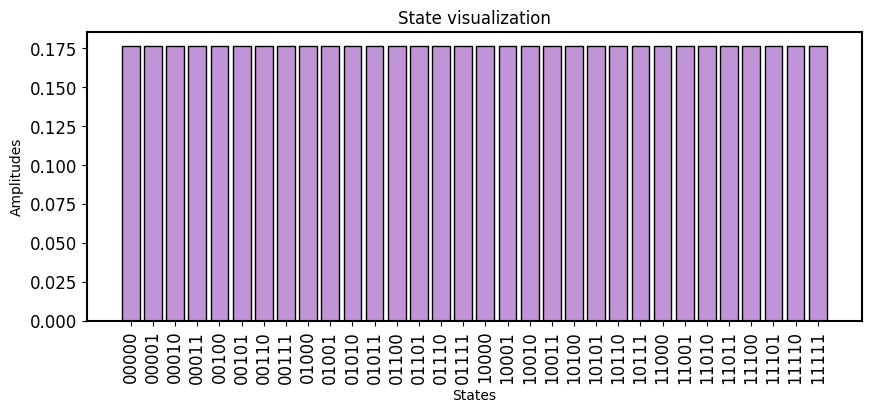

In [8]:
plot(build_initial_layer(n)().state())

#### Oracle 

We need now to construct the oracle $U_f$, a quantum circuit with the ability to recognize the target state. The oracle is a unitary operator $U_f$ whose action on the computational basis is 

$$ |x\rangle |q\rangle \xrightarrow{U_f} | x \rangle |q \oplus f(x) \rangle $$

where $f(x) = 1$ if $x$ is the solution and $0$ otherwise, $|x\rangle$ is the quantum register, $|q\rangle$ is the ancilla qubit and $\oplus$ is the addition modulo 2.

Let's have a closer at the previous equation when $x$ is not a solution, i.e. $f(x)=0$

$$ |x\rangle |q\rangle \xrightarrow{U_f} | x \rangle |q \oplus f(x) \rangle = | x \rangle |q \oplus 0 \rangle = | x \rangle |q \rangle , $$

and when $x$ is the solution, i.e. $f(x)=1$

$$ |x\rangle |q\rangle \xrightarrow{U_f} | x \rangle |q \oplus f(x) \rangle = | x \rangle |q \oplus 1 \rangle = | x \rangle X |q \rangle .$$

If the ancillary qubit is initialized in the $|-\rangle$ the application of $X$ gate results in an overall minus sign

$$ X |-\rangle = - |-\rangle .$$

Therefore we have a way to identify the solution, its amplitude will have an additional minus sign!
Basically we need to code a quantum circuit where a $X$ gate is applied to the ancilla qubit only if the quantum register is in the solution state. We are describing a controlled operation! Usually the controlled operation is performed only if the target qubit(s) are in state $|1\rangle$.

<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> Write a function that given the number of qubits and a target index creates a circuit implementing $U_f$.
    Verify the implementation by plotting the circuit which includes first the initial layer that we coded before.
    <br>
    <em> Hint: Consider first the case in which the target index is the one corresponding to the state $|1\ldots 1\rangle$. Next generalize the implementation by applying $X$ gates on the quantum register. Remember to undo these gates after the controlled operation.</em>
</div>

In [9]:
def build_oracle(guilty_index, n):
    """Swap the guilty state."""
    # we pick up the guilty string
    bitstring = bitstrings[guilty_index]
    # n+1 qubits circuit
    circuit = Circuit(n+1)
    zeros = []
    for i, bit in enumerate(bitstring):
        if bit == "0":
            zeros.append(i)
    circuit.add(gates.X(q) for q in zeros ) 
    # triggered only if the control state is |111111>
    circuit.add(gates.X(q=n).controlled_by(*range(n)))
    circuit.add(gates.X(q) for q in zeros) 
    return circuit

Let's have a look to the circuit.

In [10]:
circuit = build_initial_layer(n=n) + build_oracle(guilty_index=guilty_index, n=n)
circuit.draw()

0: ─H─X─o─X─
1: ─H───o───
2: ─H─X─o─X─
3: ─H───o───
4: ─H───o───
5: ─X─H─X───


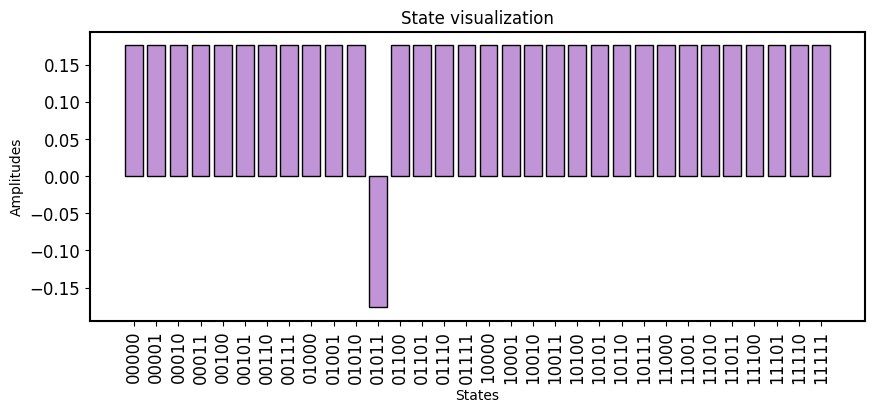

In [11]:
plot(circuit().state())

Even though the amplitude of the guilty state is flipped, if we look to the probabilies associated to the states of the input register we still collect an equally superposed state.

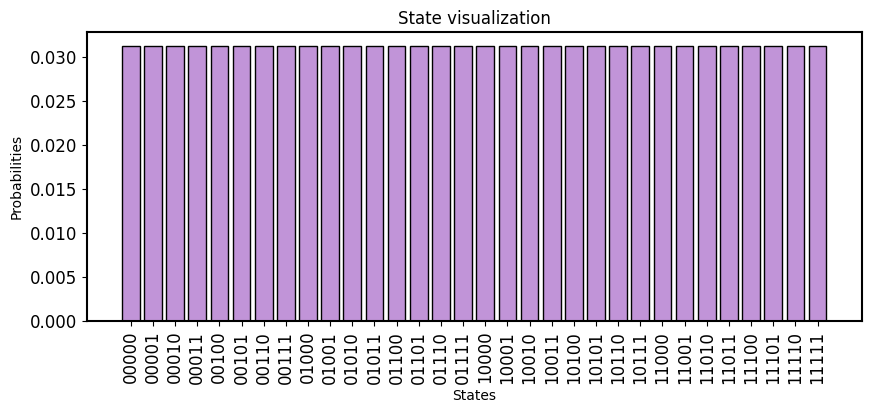

In [12]:
plot(circuit().state(), probabilities=True)

We need to find a way to amplify the probabiity of the state `01011` so that when we measure the circuit we are most likely to measure that state!

#### The diffusion operator

The next step in Grover is to implement the diffusion operator, whose effect is to amplify the guilty amplitude while decreasing the others.
$$ D = H^{\otimes n} CPS_0 H^{\otimes n}$$
where $CPS_0$ is a conditional phase shift that flips the sign of all amplitudes but the state $\ket{0}$
$$ CPS_0 \ket{x} \rightarrow - (-)^{\delta_{x0}} \ket{x} $$.
In the following we provide a function to generate the quantum circuit corresponding to the diffuser


In [13]:
def build_diffusion_operator(n):
    diffuser = Circuit(n+1)
    for i in range(n):
        diffuser.add(gates.H(i))
    for i in range(n):
        diffuser.add(gates.X(i))
    diffuser.add(gates.Z(0).controlled_by(*range(1,n)))
    for i in range(n):
        diffuser.add(gates.X(i))
    for i in range(n):
        diffuser.add(gates.H(i))
    return diffuser

In [14]:
circuit = build_initial_layer(n=n) + build_oracle(guilty_index=guilty_index, n=n) + build_diffusion_operator(n)
circuit.draw()

0: ─H─X─o─X─H─X─Z─X─H─
1: ─H───o─H─X───o─X─H─
2: ─H─X─o─X─H─X─o─X─H─
3: ─H───o─H─X───o─X─H─
4: ─H───o─H─X───o─X─H─
5: ─X─H─X─────────────


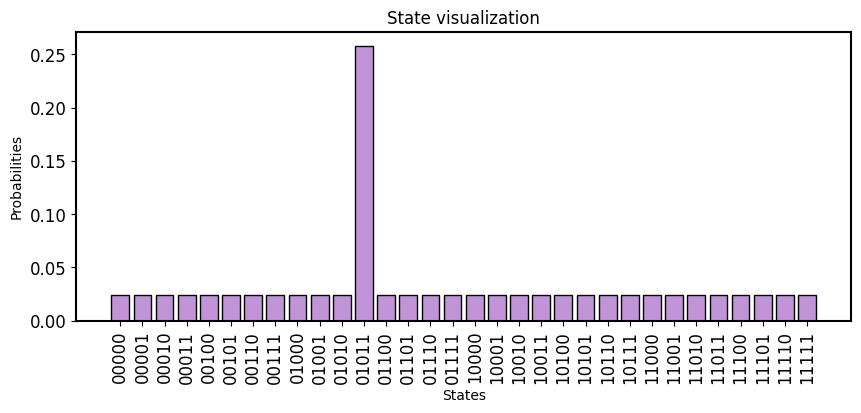

In [15]:
plot(circuit().state(), probabilities=True)

<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> Write a function that given the number of qubits and the number of steps implements the Grover algorithm.
    Both the oracle and the diffuser needs to be applied for number of times equals to the number of steps. Remember to add also measurements gates at the end.
</div>

In [16]:
def build_grover(n, nsteps):
    """Build grover circuit with `n` qubits and repeating grover iteration `steps` times."""
    # n+1 qubits circuit
    c = Circuit(n+1)
    # initial layer
    c += build_initial_layer(n)
    # repeat nstepts time oracle + diffusion operator
    for _ in range(nsteps):
        # build_oracle requires guilty_index and n
        c += build_oracle(guilty_index, n)
        # build_diffusion operator requires just n
        c += build_diffusion_operator(n)
    # final layer
    c.add(gates.M(i) for i in range(n))
    return c

In [17]:
# build grover circuit with nsteps=1
c = build_grover(n, 1)

# draw the circuit
c.draw()

0: ─H─X─o─X─H─X─Z─X─H─M─
1: ─H───o─H─X───o─X─H─M─
2: ─H─X─o─X─H─X─o─X─H─M─
3: ─H───o─H─X───o─X─H─M─
4: ─H───o─H─X───o─X─H─M─
5: ─X─H─X───────────────


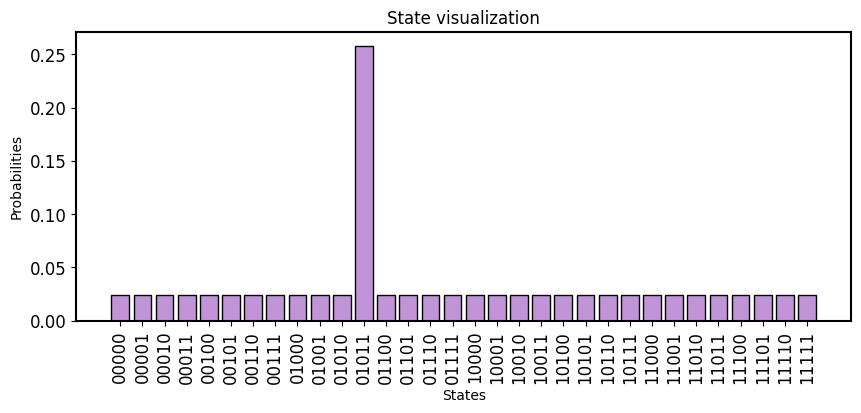

In [18]:
plot(c().state(), probabilities=True)

Now that we have added also measurements gate, we can plot the probabilities given by using a fixed number of shots as we did in the previous tutorial.

In [19]:
def visualize_states(counter):
    """Plot state's frequencies."""
        
    fig, ax = plt.subplots(figsize=(10, 5 * 6/8))
    ax.set_title('State visualization')
    ax.set_xlabel('States')
    ax.set_ylabel('#')
    plt.xticks(rotation=90)
    n = len(list(counter)[0])
    bitstrings = [format(i, f"0{n}b") for i in range(2**n)]
    for state in bitstrings:
        ax.bar(state, counter[state] if state in counter else 0, color='#C194D8', edgecolor="black")

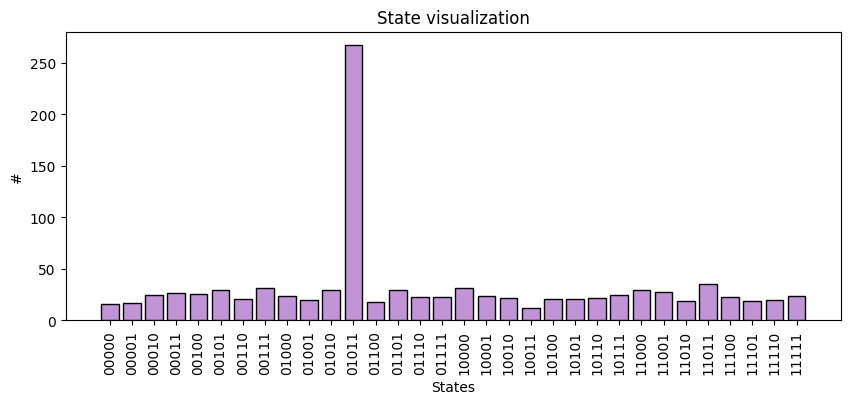

In [20]:
visualize_states(c(nshots=1000).frequencies())

In [21]:
# collect frequencies with the current circuit
frequencies = c(nshots=1000).frequencies()

# write the corresponding probabilities
probabilities = []
for bitstring in frequencies:
    probabilities.append(frequencies[bitstring] / 1000)

index = np.argmax(probabilities)
print(f"The guilty state is {bitstrings[index]} with probability {probabilities[index]}, corresponding to {names[index]}!")

The guilty state is 01011 with probability 0.281, corresponding to Jamie Arnold!


## Scaling of Grover's algorithm

We expect the optimal number of Grover steps is $\sim\pi/4 \sqrt{M}$ from the theoretical results.
Let's check what happens with a growing number of steps.

In [22]:
opt = (np.pi / 4) * np.sqrt(2**n) 
print(f"Optimal number of steps: {opt}")

Optimal number of steps: 4.442882938158366


In [23]:
# allocate empty max probabilities list
prob_target = []

# set the number of experiments, e.g. for nsteps up to 10 and use build_grover(n, nsteps)
N = 15

# check for number of steps in np.arange(0, nsteps) using the utils.compute_max_probability(c, nshots) function
for i in range(N):
    c = build_grover(n, i)
    probabilities = c(nshots=1000).probabilities(qubits=range(n-1))
    prob_target.append(np.max(probabilities))

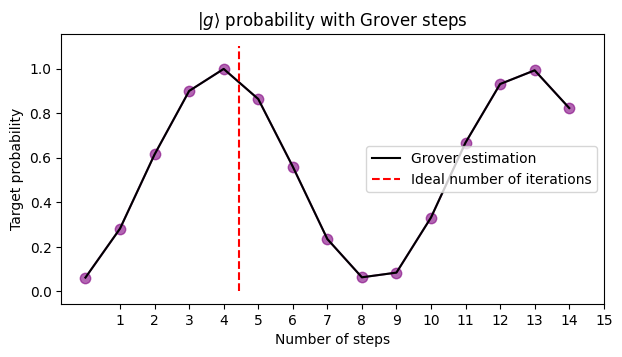

In [24]:
plt.figure(figsize=(7, 7*4/8))
plt.plot(np.arange(0, N), prob_target, ls="-", marker=".", markersize=15, alpha=0.6, color="purple")
plt.plot(np.arange(0, N), prob_target, ls="-", color="black", label="Grover estimation")
plt.vlines(opt, 0, 1.1, color="red", ls="--", label="Ideal number of iterations")
plt.xticks(np.arange(1, N+1))
plt.title(r"$|g\rangle$ probability with Grover steps")
plt.xlabel("Number of steps")
plt.ylabel("Target probability")
plt.legend()
plt.show()

References

[1] [A fast quantum mechanical algorithm for database search, 1996](https://arxiv.org/abs/quant-ph/9605043)

[2] [Quantum Computation and Quantum Information, ng, Nielsen, 2000](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE#overview)